# Homework 2 - Multilayer Perceptron
CSC413/2516: Neural Networks and Deep Learning

As with Homework 1, replace "## Your Code" lines with your implementation. Your implementation is autograded against test cases. You can run auto tests any time, be aware that you have 10 tokens per 12 hours (they regenerate every 12 hours) per homework.


In this homework you will implement a linear multilayer perceptron (Section 1), dive deeper into nonlinearities (Section 2) and modify your MLP implementation (Section 3) using the flower dataset from Homework 1. You are only allowed to use numpy -- no autodiff frameworks (torch, tensorflow, etc.).
- Linear MLP (3 points)
- Non-linear functions (1.5 points)
  1. Sigmoid
  2. ReLU
  3. ELU
  3. Implement your own non-linear function
  4. SqueLU
- ReLU-MLP (2 points)


Please disclose any external help or collaboration in the cell provided at the end of the notebook.

If we update the notebook we will update the version below.

**Notebook Version:** 1.0.3

CHANGELOG:
- Initial release
- 1.0.1 (Sep-11-2025, 15:47): typo in the linear layer definition, implement $ W X + b$ instead of $X W^T + b$
- 1.0.2 (Sep-12-2025, 15:59): added `plot_predictions` function
- 1.0.3 (Sep-15-2025, 16:49): hints for partial_derivative functions corrected

# Set-up
**! Do not change the following code**

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Tuple
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

SEED = 42
np.random.seed(SEED)

# Data Exploration
Remember the classification problem from Homework 1? We will use a slightly modified version of the same flower dataset.

In this section we create the dataset and provide utility functions for visualization. You don't need to change anything.

(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Validation Data'}>)

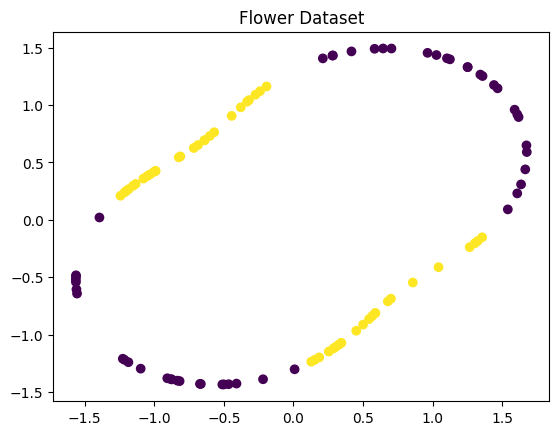

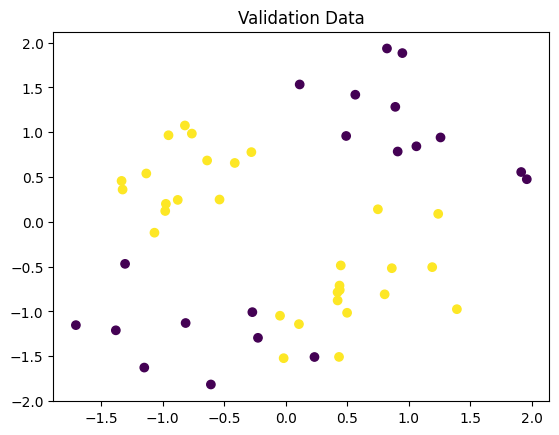

In [7]:
def generate_flower_data(
    n_samples: int = 1000, noise: float = 0.1, num_classes: int = 3, seed: int = 42
):
    rand = np.random.default_rng(seed)
    t = rand.uniform(0, 2 * np.pi, n_samples)

    # Petal shape: radius varies with class count
    r = 1 + 0.3 * np.sin(num_classes * t)

    x = r * np.cos(t) + noise * rand.standard_normal(n_samples)
    y = r * np.sin(t) + noise * rand.standard_normal(n_samples)

    X = np.stack([x, y], axis=1)

    # Assign class based on petal angle region
    labels = ((t % (2 * np.pi)) / (2 * np.pi) * num_classes * 2).astype(
        int
    ) % num_classes
    y = labels.reshape(-1, 1)

    return shuffle(X, y, random_state=seed)


def visualize_classification_data(features, labels, title: str = "Flower Dataset"):
    fig, ax = plt.subplots()
    ax.scatter(x=features[:, 0], y=features[:, 1], c=labels, cmap="viridis")
    plt.title(title)
    return fig, ax


NUM_CLASSES = 2
N_FEATURES = 2
NUM_SAMPLES = 100
np.random.seed(SEED)
flower_X, flower_y = generate_flower_data(
    num_classes=NUM_CLASSES, n_samples=NUM_SAMPLES, noise=0
)
valid_X, valid_y = generate_flower_data(
    num_classes=NUM_CLASSES, n_samples=50, noise=0.25
)

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
flower_X = scaler.fit_transform(flower_X)
valid_X = scaler.transform(valid_X)

visualize_classification_data(flower_X, flower_y)
visualize_classification_data(valid_X, valid_y, title="Validation Data")


(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Validation Data'}>)

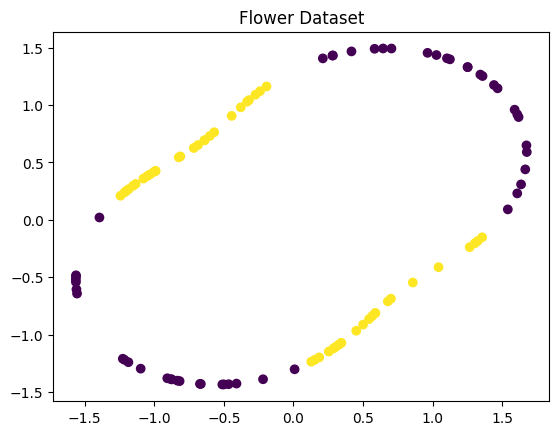

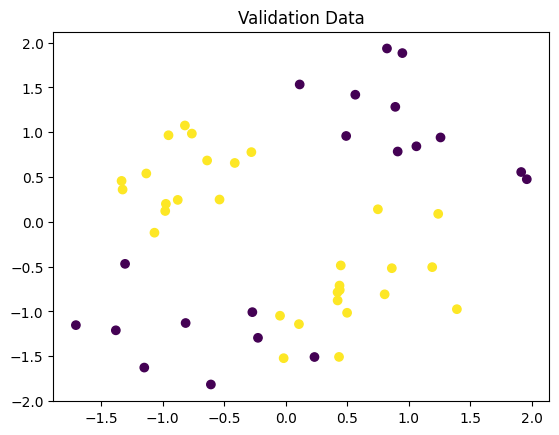

In [8]:


def plot_predictions(
    inputs, targets, model, title: str = "LinearMLP Predictions"
):
    """Utility function that plots predictions against the actual data.
    Don't modify this function
    """
    y_pred = np.argmax(model(inputs), axis=0, keepdims=True)

    fig, ax = plt.subplots()
    correct_mask = (y_pred == targets).flatten()
    print(inputs.shape, inputs.T.shape, y_pred.shape, correct_mask.shape)
    ax.scatter(
        inputs.T[correct_mask, 0],
        inputs.T[correct_mask, 1],
        c=y_pred.T[correct_mask],
        cmap="viridis",
        edgecolors="k",
        label="Correct",
    )
    ax.scatter(
        inputs.T[~correct_mask, 0],
        inputs.T[~correct_mask, 1],
        c=y_pred.T[~correct_mask],
        cmap="viridis",
        edgecolors="red",
        linewidths=1.5,
        label="Wrong",
    )

    ax.set_title(title)
    ax.set_xlabel("Feature 1")
    ax.set_ylabel("Feature 2")
    ax.legend()
    plt.show()


def visualize_classification_data(features, labels, title: str = "Flower Dataset"):
    fig, ax = plt.subplots()
    ax.scatter(x=features[:, 0], y=features[:, 1], c=labels, cmap="viridis")
    plt.title(title)
    return fig, ax


NUM_CLASSES = 2
N_FEATURES = 2
NUM_SAMPLES = 100
np.random.seed(SEED)
flower_X, flower_y = generate_flower_data(
    num_classes=NUM_CLASSES, n_samples=NUM_SAMPLES, noise=0
)
valid_X, valid_y = generate_flower_data(
    num_classes=NUM_CLASSES, n_samples=50, noise=0.25
)

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
flower_X = scaler.fit_transform(flower_X)
valid_X = scaler.transform(valid_X)

visualize_classification_data(flower_X, flower_y)
visualize_classification_data(valid_X, valid_y, title="Validation Data")


# MLP From Scratch (3 points)

Using numpy only, implement a linear MLP and complete routines to train it.
1. Implement a linear layer that computes $z = W X +b$.
The initialization of the parameters (weight and bias values) is already provided to you.
1. Implement a perceptron by filling out the `LinearMLP` class, including the forward pass (`__call__` function).
2. Implement the backward pass to compute gradients of the loss with respect to each layer’s weights and biases. Specifically,
  - Forward pass: Compute and store the activations in `compute_forward_passes`
  - Backward pass:
    - Compute and store cost errors propagated to each layer in `compute_partial_derivatives`
    - Compute the gradients of the loss with respect to each layer's weights and biases in `compute_parameter_updates`.
    - Store these gradients in the lists `weight_gradients` and `bias_gradients`, one entry per layer.
  - Use these gradients to perform gradient descent updates in `update_parameters`.

> We recommend you to first derive all the gradients and partial derivatives by hand. Draw the computation graph and write down each partial derivative and what is backpropagated to each layer.  

**Model:** Your model computes the logits
$$z_L = W_L z_{L-1} + b_L, $$

where $z_{l}$ is the output of layer $l$.

*Hint:* for the last layer with softmax and cross-entropy, the gradient simplifies to
$$
\frac{\partial L}{\partial z_L} = \frac{1}{n} \left( \text{softmax}(z_L) - y \right),
$$
which is already provided to you in `step_linear_mlp` function.

In [9]:
class Layer:
    def __init__(self, input_dim, output_dim):
        # We usually initialize the network weights randomly.
        # In the next lectures you will see that it is an important aspect for neural network training.
        # Getting the initialization right can be tricky; for now we provided you with a stable initialization scheme.
        # You can experiment with different initialization strategies later in the class.
        # Don't change this!
        self.weights = np.random.randn(
            output_dim, input_dim
        ) * np.sqrt(2.0 / input_dim)
        self.biases = np.zeros((output_dim, 1))

    def __call__(self, X):
        res = X
        ##########################################
        ## TODO: Compute the forward pass of the MLP
        ## Your Code
        # Compute ( W X + b), 0.2 points

        res = self.weights @ res + self.biases
        ###########################################
        return res


class LinearMLP:
    def __init__(self, layer_widths: List[int]):
        self.layers = []
        ##########################################
        ## TODO: Create the layers of MLP
        ## Your Code, 0.2 points

        for i in range(len(layer_widths) - 1):
          io_dim = layer_widths[i]
          op_dim = layer_widths[i+1]
          l = Layer(io_dim, op_dim)
          self.layers.append(l)
        ###########################################
        assert len(self.layers) == len(layer_widths) - 1, "The total number of layers should be len(layer_widths)-1"

    def __call__(self, inputs: np.typing.ArrayLike):
        a = inputs
        ##########################################
        ## TODO: Implement forward pass of the MLP
        ## Your code, 0.2 points
        for i in range(len(self.layers)):
          layer = self.layers[i]
          a = layer.__call__(a)
        ##########################################
        return a

## MLP Training

In [10]:
# Don't modify this cell

def softmax(logits: np.array) -> np.array:
    ## Softmax function slightly modified from Homework 1 since data is d_features x N_samples
    logits = logits - np.max(logits, axis=0, keepdims=True)
    exp = np.exp(logits)
    res = exp / np.sum(exp, axis=0, keepdims=True)
    # Remember softmax outputs a vector with same dimensions as the logits
    assert logits.shape == res.shape
    return res


def cross_entropy_loss(probs: np.array, targets: np.array) -> float:
    #  Cross-entropy loss: -1/N * sum y log p (See homework 1)
    n = targets.shape[1]
    loss = -np.sum(targets * np.log(probs + 1e-8)) / n
    return loss


In [ ]:
def compute_forward_passes(network: LinearMLP, inputs: np.typing.ArrayLike) -> List[np.typing.ArrayLike]:
    layer_outputs = [inputs]
    ##########################################
    ## TODO: Forward pass - compute each layer's output and store it for later use
    ## Hint: This is very similar to your LinearMLP implementation
    ## Your Code, 0.1 points
    for layer in network.layers:
      input = layer_outputs[-1]
      layer_outputs.append(layer.__call__(input))
    ##########################################
    assert len(layer_outputs) == len(network.layers) + 1, (
        "Layer outputs should have one more element (input) than layers"
    )
    return layer_outputs


def compute_partial_derivatives(network: LinearMLP, cost_partials: List[np.typing.ArrayLike]) -> None:
    ##########################################
    ## TODO: Compute the error signal propagated to each layer
    ## Hint: Cost partials: d L / d z_l
    ## Hint: Make sure to iterate network layers in the reversed order, i.e. starting from the last layer
    ## Your Code, 0.5 points
    for l in range(len(network.layers) - 1, 0, -1):
      cost_partials[-1] = network.layers[l+1].weights

    ##########################################
    cost_partials.reverse()
    assert len(cost_partials) == len(network.layers) + 1, (
        "Cost partials should have one more element than layers"
    )


def compute_parameter_updates(
    cost_partials: List[np.typing.ArrayLike], layer_outputs: List[np.typing.ArrayLike]
) -> Tuple[List[np.typing.ArrayLike], List[np.typing.ArrayLike]]:
    weight_gradients = []
    bias_gradients = []
    ##########################################
    ## Total: 0.8 points
    ## TODO: Compute weight gradient
    ## Your Code


    ##########################################
    ## TODO: Compute bias gradient
    ## Your Code


    ##########################################
    assert len(weight_gradients) == len(layer_outputs) - 1, (
        "Weight gradients should match number of layers"
    )
    assert len(bias_gradients) == len(layer_outputs) - 1, (
        "Bias gradients should match number of layers"
    )
    return weight_gradients, bias_gradients


def update_parameters(
    network: LinearMLP,
    weight_gradients: List[np.typing.ArrayLike],
    bias_gradients: List[np.typing.ArrayLike],
    learning_rate: float,
) -> None:
    ##########################################
    ## TODO: Perform gradient descent by applying updates to the parameters
    ## Hint: w <- w - lr * grad
    ## Your Code, 0.5 points



    ##########################################


## Train Linear MLP
(0.5 points)
Train the MLP you implemented. Do you achieve $< 0.69$ CE loss?
If not, optimize your `LINEAR_MLP_LR` and `LINEAR_MLP_NSTEPS` hyper-parameters.

In [ ]:
def step_network(network, inputs, targets, learning_rate) -> float:
    """Performs one step of training: forward pass, loss computation, backward pass, parameter update.
    Don't modify this function"""
    layer_outputs = compute_forward_passes(network, inputs)
    probs = softmax(layer_outputs[-1])
    ### Compute loss
    # Number of examples in the dataset
    n = targets.shape[1]
    loss = cross_entropy_loss(probs, targets)
    ## Backward pass
    # backpropagation
    cost_partials = [1.0 / n * (probs - targets)]
    compute_partial_derivatives(network, cost_partials)
    # compute updates
    weight_gradients, bias_gradients = compute_parameter_updates(cost_partials, layer_outputs)
    # perform updates
    update_parameters(network, weight_gradients, bias_gradients, learning_rate)
    return loss


def train_linear_mlp(mlp, learning_rate: float, n_iterations: int, inputs:np.typing.ArrayLike, targets:np.typing.ArrayLike) -> List[float]:
    losses = []
    for _ in range(n_iterations):
        loss = step_network(mlp, inputs, targets, learning_rate)
        losses.append(loss)
    return losses


inputs = flower_X.T
targets = flower_y
from sklearn.preprocessing import OneHotEncoder

targets = OneHotEncoder().fit_transform(targets).toarray().T
np.random.seed(SEED)
linear_mlp = LinearMLP([2, 8, NUM_CLASSES])
##########################################
## TODO: find correct hyper-parameters
LINEAR_MLP_LR = 1
LINEAR_MLP_NSTEPS = 100
##########################################
losses = train_linear_mlp(linear_mlp, LINEAR_MLP_LR, LINEAR_MLP_NSTEPS, inputs, targets)
print(f"Final loss {losses[-1]}")
plt.plot(losses)

(*not graded*)

Check the predictions of the model.

Looking at the predictions alone, what do you observe? Think about the short-comings of perceptron and its failure modes.

In [ ]:
plot_predictions(flower_X.T, flower_y.T, linear_mlp, "LinearMLP Predictions")
plot_predictions(valid_X.T, valid_y.T, linear_mlp, "LinearMLP Predictions on Validation Data")

# Non-Linearities (1.5 Points)
The dataset in this homework is not a linearly separable problem unlike Homework 1.

In the second half of the homework you will extend your MLP by adding non-linear activation functions.

First, in this section, you will implement elementwise nonlinearities.

In [ ]:
def relu(x: np.typing.ArrayLike) -> np.typing.ArrayLike:
    res = x
    ##########################################
    ## TODO: Compute ReLU activation,
    ## 0.15 points

    ##########################################
    assert res.shape == x.shape
    return res


def relu_derivative(x: np.typing.ArrayLike) -> np.typing.ArrayLike:
    res = x
    ##########################################
    ## TODO: Compute the gradient of ReLU with respect to its inputs
    ## assume derivative at 0 to be 0.
    ## 0.2 points

    ##########################################
    assert res.shape == x.shape
    return res


def sigmoid(x: np.typing.ArrayLike) -> np.typing.ArrayLike:
    res = x
    ##########################################
    ## TODO: Compute sigmoid activation
    ## 0.15 points

    ##########################################
    assert res.shape == x.shape
    return res


def sigmoid_derivative(x: np.typing.ArrayLike) -> np.typing.ArrayLike:
    res = x
    ##########################################
    ## TODO: Compute the gradient of sigmoid with respect to its inputs
    ## 0.15 points

    ##########################################
    assert res.shape == x.shape
    return res


def elu(x: np.typing.ArrayLike, alpha: float = 1.0) -> np.typing.ArrayLike:
    res = x
    ##########################################
    ## TODO: Compute ELU activation, see https://docs.pytorch.org/docs/stable/generated/torch.nn.ELU.html
    ## ELU(x) = x if x > 0 else alpha * (exp(x) - 1)
    ## 0.2 points

    ##########################################
    assert res.shape == x.shape
    return res


def elu_derivative(x: np.typing.ArrayLike, alpha: float = 1.0) -> np.typing.ArrayLike:
    res = x
    ##########################################
    ## TODO: Compute the gradient of elu with respect to its inputs
    ## 0.2 points

    ##########################################
    assert res.shape == x.shape
    return res

def your_nonlinear_func(x: np.typing.ArrayLike) -> np.typing.ArrayLike:
    res = x
    ##########################################
    ## TODO: Implement any nonlinear elementwise activation function
    ## You can look up other activations used in deep learning (tanh, GELU, SELU)
    ## or any suitable function
    ## 0.1 points

    ##########################################
    assert res.shape == x.shape
    return res


I decide that ReLU(x) increases too quickly so I try a new nonlinearity:

$$SqueLU(x) = \sqrt{ReLU(x)}.$$

- Implement SqueLU and its derivative in the cell below.

I figure I'm being clever by applying the ReLU before the square root so that the output is always real-valued. I train a model using this nonlinearity and immediately get NaNs. Why?


In [ ]:
def squelu(x: np.typing.ArrayLike) -> np.typing.ArrayLike:
    res = x
    ##########################################
    ## TODO: Compute the SqueLU function
    ## SqueLU = \sqrt{ReLU(x)}
    ## 0.15 points

    ##########################################
    assert res.shape == x.shape
    return res

def squelu_derivative(x: np.typing.ArrayLike) -> np.typing.ArrayLike:
    res = x
    ##########################################
    ## TODO: Compute the derivative of the SqueLU function
    ## 0.2 points

    ##########################################
    assert res.shape == x.shape
    return res


### Visualize Non-Linearities
Let's visualize these non-linearities. Before running the cell, try to sketch how each function and their derivative would look like. Do they match?

In [ ]:
xaxis = np.linspace(-4, 4, 60)
functions = [relu, sigmoid, elu, squelu]
derivative_functions = [relu_derivative, sigmoid_derivative, elu_derivative, squelu_derivative]
func_names = ["ReLU", "Sigmoid", "ELU", "SquELU"]

for func, der, name in zip(functions, derivative_functions, func_names):
    fig, axs = plt.subplots(1, 2, sharey=True, figsize=(6, 2.5))
    axs = axs.flat
    axs[0].scatter(xaxis, func(xaxis), s=2)
    axs[0].set_title(name)
    axs[1].set_title(rf"$\frac{{\partial }}{{\partial x}} {name}$")
    axs[1].scatter(xaxis, der(xaxis), s=2)
    axs[1].set_xlim(xaxis[0], xaxis[-1])
    fig.suptitle(name)

# Implement ReLU MLP (2 Points)
Now implement the ReLU MLP, which will only differ in the intermediate layer outputs, where
$$
z_{l} = \sigma(h_l)\\
h_l = W_l z_{l-1} + b_{l-1}
$$
for $l < L$. We will call $h_l$ pre-activations and $z_l$ activations.


In [ ]:
class ReLUMLP:
    def __init__(self, layer_widths: List[int]):
        self.layers = []
        ##########################################
        ## TODO: Create the layers of MLP
        ## Hint: This is the same as LinearMLP initialization
        ## Your Code, 0.2 points


        ##########################################

    def __call__(self, X: np.typing.ArrayLike) -> np.typing.ArrayLike:
        res = X
        ##########################################
        ## TODO: Implement forward pass of the ReLU MLP
        ## Hint: Don't forget to apply ReLU after each layer except the last
        ## Your code, 0.3 points





        ##########################################
        return res


## ReLU-MLP Training

In [ ]:
def compute_relu_mlp_forward_passes(
    network: LinearMLP, inputs: np.typing.ArrayLike
) -> Tuple[List[np.typing.ArrayLike], List[np.typing.ArrayLike]]:
    layer_outputs = [inputs]
    pre_activations = [inputs]
    ##########################################
    ## TODO: Forward pass - compute each layer's pre-activations (h_l) and activations (z_l, after ReLU)
    # and store them for later use
    ## Your Code, 0.2 points


    ##########################################
    assert len(layer_outputs) == len(network.layers) + 1, (
        "Layer outputs should match number of layers"
    )
    assert len(pre_activations) == len(network.layers) + 1, (
        "Pre-activations should match number of layers"
    )
    return layer_outputs, pre_activations


def compute_relu_mlp_partial_derivatives(
    network: LinearMLP, cost_partials: List[np.typing.ArrayLike], pre_activations
):
    for ind, (layer, pre_activation) in enumerate(
        zip(reversed(network.layers), reversed(pre_activations))
    ):
        ##########################################
        ## TODO: Compute the error signal propagated to each layer
        ## Hint: After reversal, cost_partials[i]: d L / d z_i
        ## Hint: Cost partials: d L / d z_l = d L / d z_{l+1} * d z_{l+1} / d h_{l+1} * d h_l / d z_l
        ## where h_l is the pre-activation
        ## Your Code, 0.3 points
        pass


    ##########################################
    cost_partials.reverse()
    assert len(cost_partials) == len(network.layers) + 1, (
        "Cost partials should have one more element than layers"
    )


def compute_relu_mlp_parameter_updates(
    cost_partials: List[np.typing.ArrayLike],
    pre_activations: List[np.typing.ArrayLike],
) -> Tuple[List[np.typing.ArrayLike], List[np.typing.ArrayLike]]:
    weight_gradients = []
    bias_gradients = []
    ##########################################
    ## Total: 0.6 points
    ## TODO: Compute weight gradient
    ## Your Code


    ##########################################
    ## TODO: Compute bias gradient
    ## Your Code

    ##########################################
    assert len(weight_gradients) == len(pre_activations) - 1, (
        "Weight gradients should match number of layers"
    )
    assert len(bias_gradients) == len(pre_activations) - 1, (
        "Bias gradients should match number of layers"
    )
    return weight_gradients, bias_gradients


def step_relu_network(network, inputs, targets, learning_rate) -> float:
    # Don't change this function but please understand it
    layer_outputs, pre_activations = compute_relu_mlp_forward_passes(network, inputs)
    probs = softmax(layer_outputs[-1])
    ### Compute loss
    # Number of examples in the dataset
    n = targets.shape[1]
    ##  Cross-entropy: -1/N * sum y log p (See homework 1)
    loss = cross_entropy_loss(probs, targets)

    # backpropagation
    weight_gradients = []
    bias_gradients = []
    cost_partials = [1.0 / n * (probs - targets)]
    compute_relu_mlp_partial_derivatives(network, cost_partials, pre_activations)
    weight_gradients, bias_gradients = compute_relu_mlp_parameter_updates(cost_partials, pre_activations)
    update_parameters(network, weight_gradients, bias_gradients, learning_rate)
    return loss


## Train ReLU-MLP
(0.5 points) Train the ReLU-MLP you implemented. Do you achieve $< 0.1$ CE loss?
If not, optimize your `RELU_MLP_LR` and `RELU_MLP_NSTEPS` hyper-parameters.

In [ ]:
def train_relu_mlp(mlp, learning_rate: float, n_iterations: int,
                   inputs: np.typing.ArrayLike, targets: np.typing.ArrayLike) -> List[float]:
    losses = []
    for _ in range(n_iterations):
        loss = step_relu_network(mlp, inputs, targets, learning_rate)
        losses.append(loss)
    return losses

## Pay attention to the shape of the input
inputs = flower_X.T
targets = flower_y
from sklearn.preprocessing import OneHotEncoder
np.random.seed(SEED)
targets = OneHotEncoder().fit_transform(targets).toarray().T
relu_mlp = ReLUMLP([2, 16, 16, NUM_CLASSES])
##########################################
## TODO: find correct hyper-parameters
RELU_MLP_LR = 1
RELU_MLP_NSTEPS = 100
##########################################
losses = train_relu_mlp(relu_mlp, RELU_MLP_LR, RELU_MLP_NSTEPS, inputs, targets)
print(f"Final loss {losses[-1]}")
plt.plot(losses)
plot_predictions(flower_X.T, flower_y.T, relu_mlp, "ReLUMLP Predictions")
plot_predictions(valid_X.T, valid_y.T, relu_mlp, "ReLUMLP Predictions")

# Collaboration / External Help
Disclose any help you used (LLM usage, blogs, search, Github links, etc) and collaborations with your classmates. If you  completed the homework on your own, you can leave this part empty.

> TODO